# 03: PyTorch Exploration

For this exploration notebook I wanted to take a look at pytorch which is also a pretty popular deep learning library. In fact, PyTorch has a strong connection to numpy which makes is particularly easy to learn for beginners that already know numpy and python. Compared to Tensorflow PyTorch seems to add less overhead effort when writing the code for a neural network. For instance, before Tensorflow 2.0 people had to handle placeholders and sessions. However, PyTorch networks might be a little harder to deploy because Tensorflow is widely adopted and supported. Nonetheless, PtTorch is gaining some momentum and might be a competitive rival to Tensorflow.

Too understand some core parts of PyTorch I wanted to use the MNIST dataset and build a small convolutional neural network using PyTorch. Since I already trained some networks with Tensorflow/Keras and MNIST I wanted to see what are the differences of both frameworks. But first I checked out some basic functionalities like Tensors and convolutional layers with PyTorch.

#### Installation
To use PyTorch on your machine you simply need to use the following conda command. It seems that there is a special dependency called torchvision. This package contains "popular datasets, model architectures, and common image transformations for computer vision" according to the PyTorch documentation. The conda command is:

```shell
conda install pytorch torchvision -c pytorch
```

In [187]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

#### Playground

First, I tried to initialize a new random Tensor which seems to be very easy. According to the documentation a numpy array is basically a Tensor. That means that you can switch between both types. However, if you change one variable that will also reflect all the other variables that were derived using the changed var because it's still the same object in memory:

In [168]:
x1 = torch.rand(1,2)
print(x1)
x2 = x1.numpy()
print("numpy(", x2, ")", sep="")
print()

x2[0,0] = 1

print(x1)
print("numpy(", x2, ")", sep="")

tensor([[0.0630, 0.2087]])
numpy([[0.06301582 0.20872039]])

tensor([[1.0000, 0.2087]])
numpy([[1.         0.20872039]])


Secondly, I wanted to take a look at the convolutional layers and see how they work. Therfore, I initialized a random Tensor and applied a convolutional filter to the Tensor. The result is a new Tensor. I was primariily interested in the shape of the resulting Tensor. I wanted to do this because the neural network I wanted to build should involve conv layers. As a result, i need to know the dimensions of the tensors that I pass into the subsequent layers:

In [169]:
m = nn.Conv2d(1, 10, kernel_size=5, padding=(2,0))
input = torch.randn(1, 1, 28, 28)
output = m(input)

print(input.shape)
print(output.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 10, 28, 24])


You can see that the padding (2, 0) adds padding values to the left and right side of the image. As a result, the output shape has the same dimension from left to right as the input Tensor image. The first dimension of the vector denotes the batch dimension while the subsequent dimensions describe the image itself.

The kernel of size 5 is a 5x5 mask that will be moved over the whole image. The kernel computes the dot product of it's values with the values of the area that it covers at a time. Basically a kernel generates features for a single cell by looking at the values of the surounding cells. If there is no padding at all the kernel needs to stay 2 cells away from the image to calculate the value at the center of the kernel. A 28x28 image would shrink on each side by 2 pixels which results in a 24x24 image. By adding a padding of 2 to each side you would get a 28x28 image again.

#### Data

To get the data for our MNIST network you can initialize a data loader which is given by PyTorch. PyTorch also allows you to use transformations which will be applied to each sample in the given dataset. In our case we convert each 1x28x28 image to a Tensor. As a result we will get a List or DataLoader of 60000 samples with 1x28x28 images. A nice feature is the normalize transform which allows you to normalize each value using the given normalization values. The first value denotes the mean and the second value the standard deviation.

The data will be stored in the given directory. Furthermore you can specify if the data should be shuffeld which should be the case and you can specify the batch size for your training and testing loop. This seems to be a big difference compared to Keras and Tensorflow. For those frameworks you would need to specify the batch size in the fit function.

In [170]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True
                               , transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(), 
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
    , batch_size=64, shuffle=True)


test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True
                               , transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
    , batch_size=64, shuffle=True)

#### Network
To create a new PyTorch network you simply need to build a new python class which extends from the nn.Module. In the constructor of the class you should initialize all the layers that you need. In the forward function of the class you need to specify how the forward pass through the network is defined. Personally I had two major questions:

1. Can you reuse layers which you specified in your constructor for multiple times?
    - Yes you can reuse a layer multiple times within the forward pass function.
2. What is the view function for and what does the function compute?
    - Basically reshapes the given tensor. In this case we try to flatten the tensor.

In [180]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5,5))
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(5,5))
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [181]:
network = MNIST_Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)

#### Training/Testing
A major difference to Tensorflow and Keras is that you need to code the training process (fit) and testing process (evaluate) by yourself. For example, that also means that you need to keep track of the training history by yourself. Thus, we need to initialize two list to store the losses or training accuracies. Later you could visualize the loss over time.

To run the training loop you basically only need to setup a loop that calls the train and test function to generate validation results. This whole process might look a little tricky but it also allows you to customize everything depending on your needs.

In [182]:
train_losses = []
test_losses = []

In [183]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())

In [184]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [185]:
test()
for epoch in range(1, 3 + 1):
    train(epoch)
    test()


Test set: Avg. loss: 2.3236, Accuracy: 958/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.359157
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.175403
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.485162
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.167926
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.785056
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.689566
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.601035
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.533913
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.629176
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.626975

Test set: Avg. loss: 0.2087, Accuracy: 9350/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.445065
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.503924
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.337413
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.556463
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.244589
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.418317
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.218889
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.8046

#### Visualizations

Let's visualize the loss over training time:

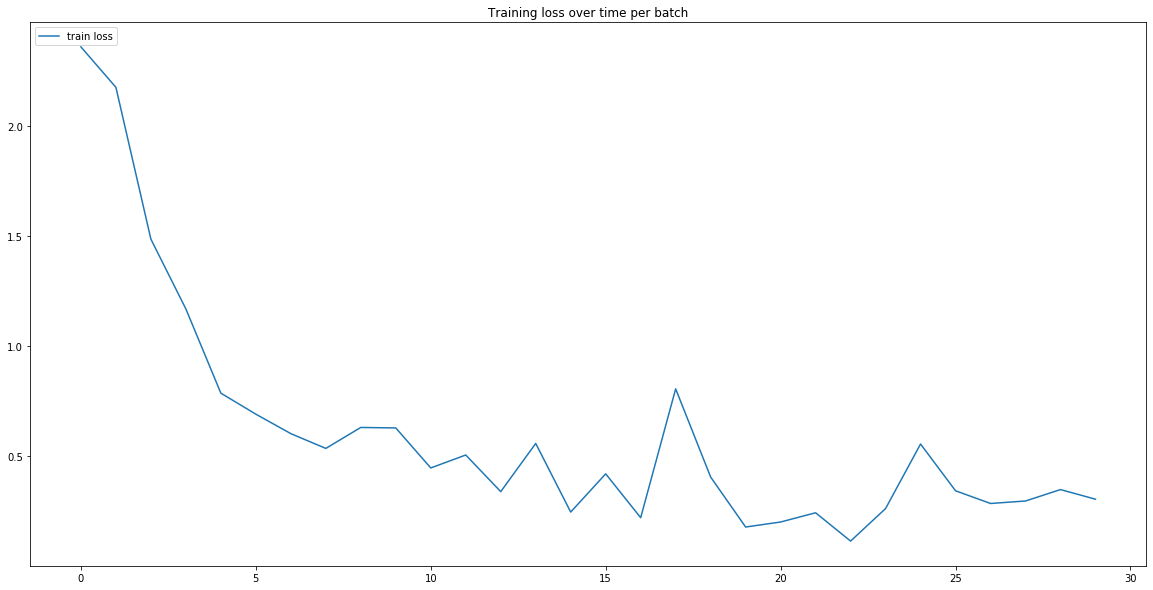

In [197]:
plt.figure(figsize=(20,10))
plt.plot(train_losses)
plt.legend(["train loss"], loc="upper left")
plt.title("Training loss over time per batch")
plt.show()

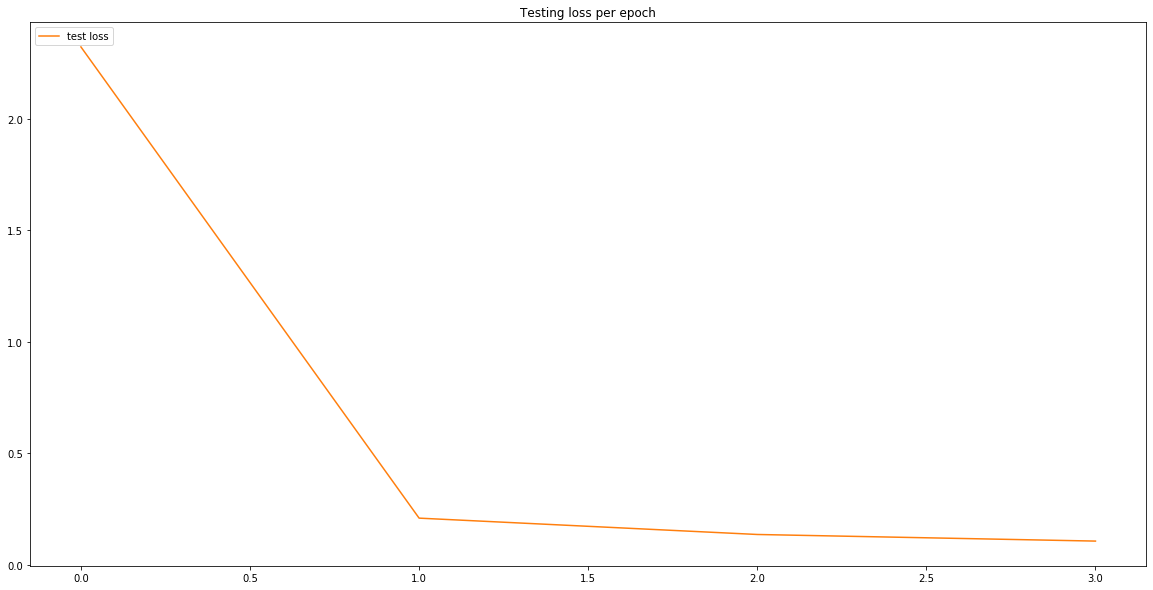

In [201]:
plt.figure(figsize=(20,10))
plt.plot(test_losses, c="C1")
plt.legend(["test loss"], loc="upper left")
plt.title("Testing loss per epoch")
plt.show()

## Takeaways

1. You need to specify the batch size in the dataloader. Compared to Keras and Tensorflow which allow to specify the batch_size in the fit/evaluate/predict function this is a big difference. However, if there is no dataloader you can probably also specify the batch size in your training/testing function. Instead of using the following line of code you can probably define your own way of feeding the data into the network.

```python
for batch_idx, (data, target) in enumerate(train_loader):
```

2. You can add prints everywhere which makes it so much easier to debug the whole network and its dimensions. ALthough some of the error messages are hard to understand you can always add print statements in your forward pass of your network module. In fact, you only need to add the following line to understand the dimensions of your network.

```python
print(x.shape)
```

3. You can customize the training loop very strongly. As already said, it seems to be very tricky and error prone to define your own training and testing loop. Nonetheless, I think that you can probably copy paste these functions to every new project to make sure to not introduce unnecessary bugs. Additionally, this process allows you to customize a lot of things. For instance, if you have a special way of keeping track of your losses you can do this with PyTorch.
